In [1]:
# increase default window size for notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/tmp/ipykernel_23107/696421802.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Set reproducible results by random seeding, answer from here: https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds

# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K

# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
K.set_session(sess)

2022-08-28 14:04:34.184601: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-28 14:04:34.184634: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: avt-System-Product-Name
2022-08-28 14:04:34.184643: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: avt-System-Product-Name
2022-08-28 14:04:34.184713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.82.1
2022-08-28 14:04:34.184737: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.82.1
2022-08-28 14:04:34.184745: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.82.1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import timeit
from datetime import timedelta
from dataclasses import dataclass       # C like structure
import glob                             # finds all the pathnames matching specified pattern
import datetime as dt
import random
!python --version
print('pandas version: ' + pd.__version__)
print('numpy version: ' + np.__version__)

Python 3.9.7
pandas version: 1.4.1
numpy version: 1.21.2


In [4]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants

imported custom_plot.py
data_clean imported
data_preprocess imported


In [5]:
%matplotlib notebook
# Plot related packages,%matplotlib notebook makes plots in jupyter interactive
# constants for plotting
x_label_elapsedtime = 0
x_label_datetime = 1

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [7]:
# Load processed data (phase 1)

dir_path = os.path.join(cwd, 'csv')
filename = 'cell_cycles.pkl'

# load last saved df from phase1 data and convert time stamp and sort
li_ts_cycles_ph1 = data_preprocess.load_object(dir_path, filename)

In [8]:
# Load processed data (phase 2)
dir_path = os.path.join(cwd, 'csv', 'phase_2_pkl')
filename = 'mod1_cell_cycles.pkl'
li_ts_cycles_ph2 = data_preprocess.load_object(dir_path, filename)

In [9]:
# Combine phase1 and phase 2 data
import math

# for x, y in li_ts_cycles_ph1:
#     print('phase1 cells', x, y)
    
# for x, y in li_ts_cycles_ph2:
#     print('phase2 cells', len(y))

combined_phase_cycles = []
if len(li_ts_cycles_ph1) <= len(li_ts_cycles_ph2):
    for i in range(len(li_ts_cycles_ph1)):              # each cell contain multiple cycles
        c_1, cycles_1 = li_ts_cycles_ph1[i]                 # for example, (v1, [cycles])
        c_2, cycles_2 = li_ts_cycles_ph2[i]
        if (c_2 == c_1):
            cycles_1 += cycles_2                        # this adds cycle to li_ts_cycles_ph1
    combined_phase_cycles = li_ts_cycles_ph1
else:
    for i in range(len(li_ts_cycles_ph2)):              # each cell contain multiple cycles
        c_2, cycles_2 = li_ts_cycles_ph2[i]
        c_1, cycles_1 = li_ts_cycles_ph1[i]
        if (c_2 == c_1):
            cycles_2 += cycles_1                        # this adds cycle to li_ts_cycles
    combined_phase_cycles = li_ts_cycles_ph2


for x, y in combined_phase_cycles:
    print('combined cells', x)

combined cells V1
combined cells V2
combined cells V3
combined cells V4
combined cells V5
combined cells V6
combined cells V7
combined cells V8
combined cells V9
combined cells V10
combined cells V11
combined cells V12


In [10]:
import math

# Separate training, validation and test cycles, keep cycles without cell ID
TRAIN_SAMPLES = 0.9
li_train_cycles = []      # each of this list is a separate static_dynamic_static cycle
# li_validation_cycles = []
li_test_cycles= []
counter = 0

total_cycles = 0
for (c, li_cycles) in combined_phase_cycles:              # each cell contain multiple cycles
    counter += 1
    num_cell_cycles = len(li_cycles)
    num_train_cycles = math.floor(num_cell_cycles * TRAIN_SAMPLES)                 # training cycle samples 70%
    # num_validation_cycles = math.ceil((num_cell_cycles - num_train_cycles) * 0.5)
    # num_test_cycles = num_cell_cycles - num_validation_cycles - num_train_cycles
    num_test_cycles = num_cell_cycles - num_train_cycles
    total_cycles += len(li_cycles)
    # print(num_cell_cycles, num_train_cycles, num_validation_cycles, num_test_cycles)

    li_train_cycles += li_cycles[0:num_train_cycles]
    # li_validation_cycles += li_cycles[num_train_cycles:num_train_cycles+num_validation_cycles]
    # li_test_cycles += li_cycles[num_train_cycles+num_validation_cycles:]
    li_test_cycles += li_cycles[num_train_cycles:]
    break

print(total_cycles, len(li_train_cycles), len(li_test_cycles))     # test

17 15 2


In [31]:
%matplotlib notebook
# Take only OCV part
li_ocv = []

for i, df in enumerate(li_train_cycles):
    if (i != 0 and i != 13):    # these have less than 160 len
        df_each = df.copy()
        df_ocv = df_each.tail(200) # last 160 elements (only OCV)
#         print(len(df_ocv))
        li_ocv.append(df_ocv)

<IPython.core.display.Javascript object>


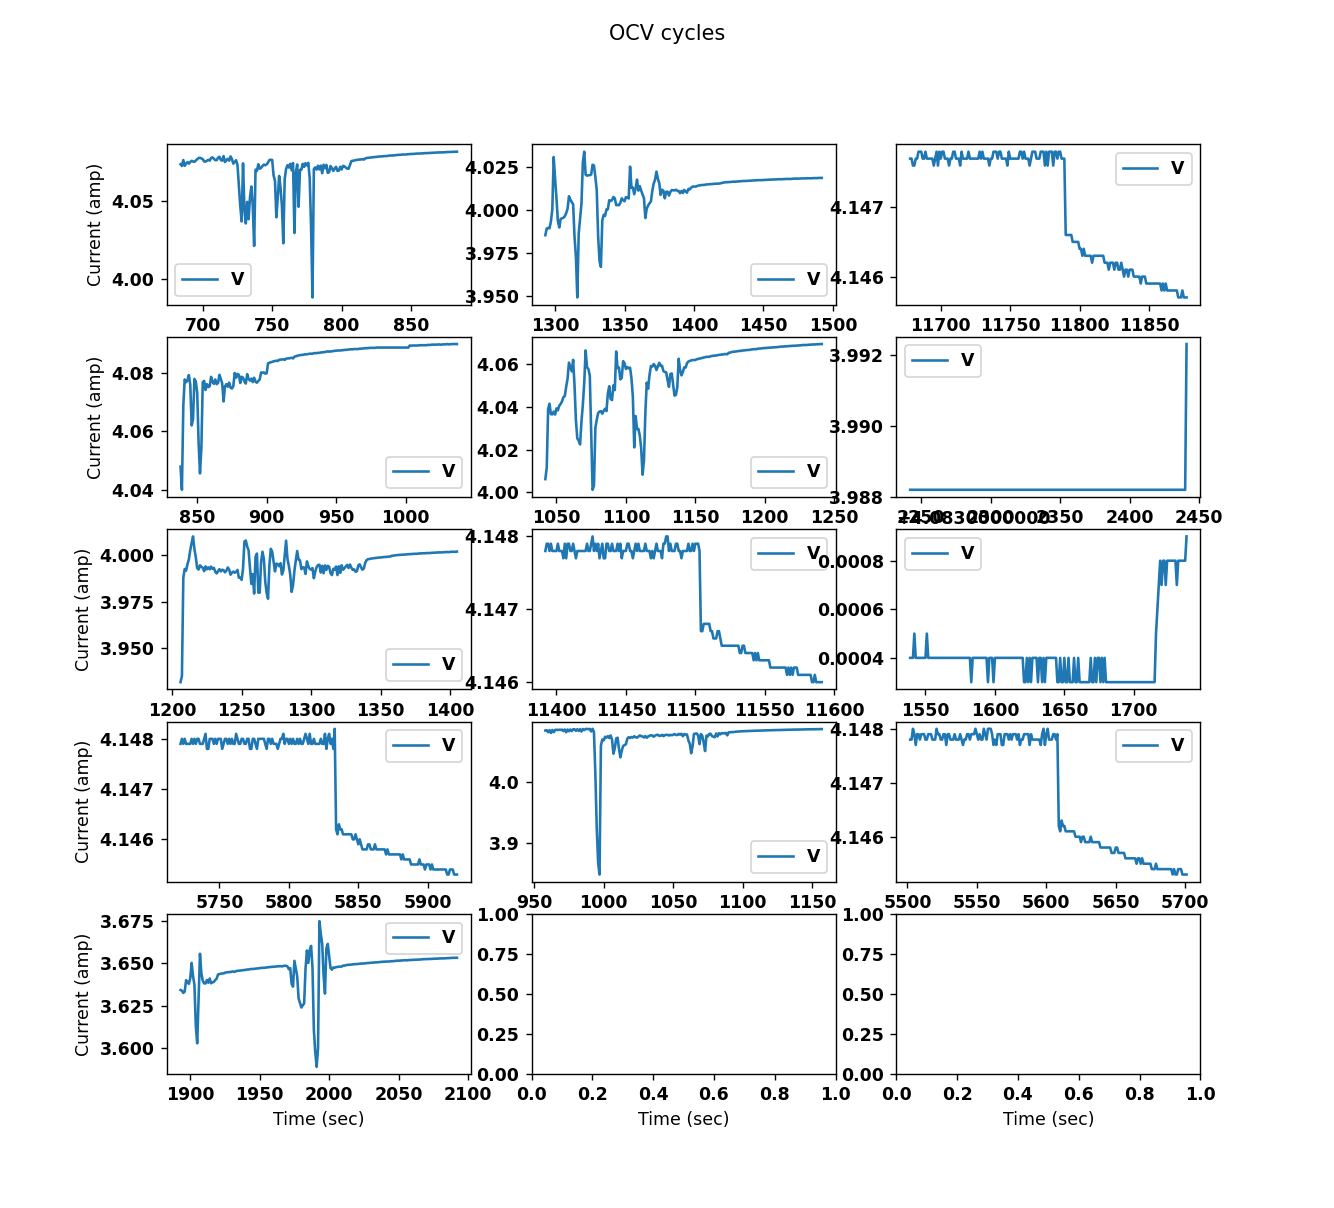

i:  0   j:  0
i:  0   j:  1
i:  0   j:  2
i:  1   j:  0
i:  1   j:  1
i:  1   j:  2
i:  2   j:  0
i:  2   j:  1
i:  2   j:  2
i:  3   j:  0
i:  3   j:  1
i:  3   j:  2
i:  4   j:  0


In [32]:
# plot ocv cycles
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set save path for plot
fig_path = os.path.join(cwd, 'figures')
plot_path = os.path.join(fig_path, 'ocv_currents.pdf')

cols = 3
total_train_cycles = len(li_ocv)
rows = math.ceil(total_train_cycles / cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

i = -1        # row index
j = 0        # col index
# Plot multiple train cycles voltages
for df in li_ocv:
    if (j % cols == 0):
        j = 0
        i += 1     # first entrance makes i = 0
    print('i: ', i, '  j: ', j)
    df_each = df.copy()
    df_each.plot(x='elapsed_sec', y='V', ax = axes[i][j], title='OCV cycles', subplots=True)
#     ax.set_title(f'Title {i}')
    j += 1

# set labels
plt.setp(axes[-1, :], xlabel='Time (sec)')
plt.setp(axes[:, 0], ylabel='Current (amp)')
plt.show()
plt.savefig(plot_path)

In [12]:
def df_to_supervised_multivariate(df_as_np, input_window, label_index, output_window=1):
    X = []
    y = []
    for i in range(len(df_as_np) - input_window):
        X.append(df_as_np[i:i+input_window, 0:df_as_np.shape[1]])
        label = df_as_np[i+input_window][label_index]    # index of output label ie voltage
        y.append(label)
    return np.array(X), np.array(y)
    return X, y

In [ ]:
# Convert training data to supervised learning

# Many to one supervised learning
TIMESTEPS = 10
train_X = []
train_y = []
for df in li_train_cycles:
    df_each = df.copy()
    df_each = df_each[['V', 'current', 'Temp']]   # only necessary columns
    X, y = df_to_supervised_multivariate(df_each.to_numpy(), TIMESTEPS, 0)  # for each cycle (TS), X and Y

    # combine all the train cycles
    train_X += X.tolist()
    train_y += y.tolist()

train_X = np.array(train_X)   # convert to np array
train_y = np.array(train_y)

print(train_X.shape)
print(train_y.shape)
